<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em; font-weight: bold"> Statistical Modelling - Perceived Sleepiness </span><br>
</div>

---

### Table of contents

#### [1. Loading required libraries](#section1)
 
#### [2. Loading Data](#section2)

#### [3. Preparing Data to Regression Analysis](#section3)

###### [3.1. Counting and Removing NaN rows](#section31)

#### [4. Regression Analysis](#section4)

###### [4.1. Counting and Removing NaN rows](#section41)

###### [4.2. First Iteration](#section42)

###### [4.3. Second Iteration](#section43)

###### [4.4. Third Iteration](#section44)

---

# 1. Loading required libraries <a name="section1"></a>

In [1]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

---

# 2. Loading Data <a name="section2"></a>

In [2]:
file = os.path.join('data','processed_to_regression.csv')
df = pd.read_csv(file)

df.head(5)

,Id,Record_time_stamp,kss,sps,time_fill_kss_sps,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


In [3]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,Record_time_stamp,kss,sps,time_fill_kss_sps,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


---

# 3. Preparing Data to Regression Analysis <a name="section3"></a>

The sps and kss scales were taken along each workloads in three moments, at start, at middle and at end. As the pilots workloads are irregular, these three moments can occur at different hours along the day in the EM, MOR, AFT, EVE, NI.

To tackle this kind of problem a mixed model with control in participant is ideal, i.e. a model whith a random intercept for each participant. However, the measurements were taken irregularly along various hours of the day, so we will assume another random intercept and a random slope in the variable time the participants filled kss and sps scales.

## 3.1. Counting and removing nan rows <a name="section31"></a>

### 3.1.1. Function to diplay side by side

In [4]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [5]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
time_fill_kss_sps,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without great impacts in forward analysis

### 3.1.3. Removing NaN rows

In [6]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
time_fill_kss_sps,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


### 3.1.4. Re-scaling some variables

In [7]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()/10
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

**Now the data is ready for analysis!**

---

# 4. Regression Analysis <a name="section1"></a>

Given the experimental design discussed in [Feature_Engineering.ipynb](Feature_Engineering.ipynb),  we choose a mixed logistic model or multilevel logistic model

<p style="text-align: center;"> $g(x_{ij},\beta_{0i},\beta_1, \beta_s) = \beta_{0i}+\beta_{1i}x_1 + x_{ij}^T\beta_s$  (level 1) </p>
<p style="text-align: center;"> $\beta_{0i} = \beta_0 + \alpha_i$  (level 2, random intercept) </p>
<p style="text-align: center;"> $\beta_{1i} = \beta_1 + \tau_i$  (level 2, random slope) </p>

where $\alpha_i \sim N(0,\sigma_\alpha^2)$ and $\tau_i \sim N(0,\sigma_\tau^2)$ with $\alpha_i \perp \tau_i$.

In our setting, the random slope is due to time the participants filled the scales and the random intercept is due to participant cluster and time the participant filled the scales.

## 4.1. Function to codify formula in statsmodel standard <a name="section41"></a>

In [8]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.2. First Iteration <a name="section42"></a>

In [9]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_type_prev_es','workload_type_prev_nt',
              'workload_length','sleep_duration','time_awake','Position','Num_Sons','flight_hours','education',
              'marital_status','time_displacement','age','Num_Sons','Classification']

formula = get_formula(covariates, 'kss')

md = smf.mixedlm(formula, working_df, groups=working_df["Id"], re_formula = 'time_fill_kss_sps')
mdf = md.fit()
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               kss       
No. Observations:                1014                  Method:                           REML      
No. Groups:                      43                    Scale:                            2.1305    
Min. group size:                 8                     Log-Likelihood:                   -1903.4024
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 23.6                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

Using the Wald test (P>|z|) at level of 5%, we can reject variables related to previous workloads (workload_type_es and workload_type_nt), number of sons and age. The variable workload_type will be recategorized, meaning just an indicator of night routines.

So, follows the second iteration.

## 4.3. Second Iteration <a name="section43"></a>

In [14]:
covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','education','Classification','age','sleep_duration']

formula = get_formula(covariates, 'kss')

working_df2 = working_df.copy()
working_df2['workload_type'] = working_df2['workload_type'].apply(lambda x: 'others' if x=='early-start' else x)

md = smf.mixedlm(formula,working_df2, groups=working_df2["Id"], re_formula = 'time_fill_kss_sps')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf = md.fit()
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               kss       
No. Observations:                1014                  Method:                           REML      
No. Groups:                      43                    Scale:                            2.1254    
Min. group size:                 8                     Log-Likelihood:                   -1900.1582
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 23.6                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

As we can see, all variables considered is found significant at the level of 5%. However, some more analysis is found needed to choose this model as the best model or a parsimonious model.

At first we will plot the model coefficients in terms of odds ratio and evaluate if it is needed to collapse some categorical variable such as "workload_moment" or "workload_type". 

Text(0.5, 1.0, 'Perception of Sleepiness Odds ratio')

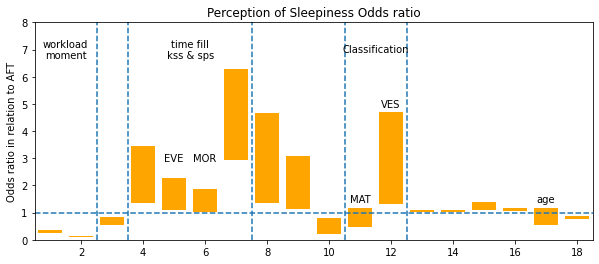

In [18]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf.conf_int())[1:19]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'orange')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 7.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 10.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 12.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment', horizontalalignment='center',verticalalignment='center')
ax.text(5.5,7,'time fill\n kss & sps', horizontalalignment='center',verticalalignment='center')
ax.text(11.5,7,'Classification', horizontalalignment='center',verticalalignment='center')
ax.text(5,3,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,3,'MOR', horizontalalignment='center',verticalalignment='center')
ax.text(11,1.5,'MAT', horizontalalignment='center',verticalalignment='center')
ax.text(12,5,'VES', horizontalalignment='center',verticalalignment='center')
ax.text(17,1.5,'age', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 18.5])
ax.set_ylabel('Odds ratio in relation to AFT')
ax.set_title('Perception of Sleepiness Odds ratio')

Figure above presents the 95% odds ratio interval for all covariates.

* For time the participant fill kss scale covariate, we can see a lot of overlapping between categories EVE and MOR, indicating that these two categories can be merged into a single category. However, the interpretability of the result (EVE does not follow MOR period) obligates us to keep this variable as it is.

* For Classification, the MAT category has the 95% confidence bound ranging from positive to negative values, indicating that MAT (Matutine) category does not differ in terms of odds ratio of the baseline category, i.e. INT (Intermediary), so MAT and INT categories can be merged into a single category, MAT_INT.

* Age covariate is not found statistically significant at the level of 5%.

So, follows the third iteration.

## 4.4. Third Iteration - Parsimonious Model <a name="section44"></a>

In [19]:
covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','education','Classification','sleep_duration']

formula = get_formula(covariates, 'kss')

working_df3 = working_df2.copy()
working_df3['Classification'] = working_df3['Classification'].copy().apply(lambda x: 'MAT_INT' if x in ['MAT','INT'] else x)

md3 = smf.mixedlm(formula,working_df3, groups=working_df3["Id"], re_formula = 'time_fill_kss_sps')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf3 = md3.fit()
print(mdf3.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               kss       
No. Observations:                1014                  Method:                           REML      
No. Groups:                      43                    Scale:                            2.1267    
Min. group size:                 8                     Log-Likelihood:                   -1900.8341
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 23.6                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

Above it is shown the output of the chosen model!

### 4.4.1. Coefficients Interpretation

Logistic model coefficients can be interpreted as odds ratio. Due to the link function, odds ratio is obtained through exponentiation of the coefficient, so:

<p style="text-align: center;"> odds ratio = exp(coefficient) </p><br>


we will apply this rationale to all fixed effects and random slope parameters.

Text(0.5, 1.0, 'Perception of Sleepiness Odds ratio - Parsimonious Model')

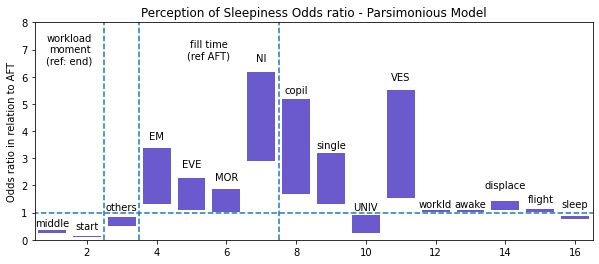

In [33]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf3.conf_int())[1:17]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'slateblue')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 7.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment\n(ref: end)', horizontalalignment='center',verticalalignment='center')
ax.text(5.5,7,'fill time\n(ref AFT)', horizontalalignment='center',verticalalignment='center')
ax.text(1,.6,'middle', horizontalalignment='center',verticalalignment='center')
ax.text(2,.5,'start', horizontalalignment='center',verticalalignment='center')
ax.text(3,1.2,'others', horizontalalignment='center',verticalalignment='center')
ax.text(4,3.8,'EM', horizontalalignment='center',verticalalignment='center')
ax.text(5,2.8,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,2.3,'MOR', horizontalalignment='center',verticalalignment='center')
ax.text(7,6.7,'NI', horizontalalignment='center',verticalalignment='center')
ax.text(8,5.5,'copil', horizontalalignment='center',verticalalignment='center')
ax.text(9,3.5,'single', horizontalalignment='center',verticalalignment='center')
ax.text(10,1.2,'UNIV', horizontalalignment='center',verticalalignment='center')
ax.text(11,6,'VES', horizontalalignment='center',verticalalignment='center')
ax.text(12,1.3,'workld', horizontalalignment='center',verticalalignment='center')
ax.text(13,1.3,'awake', horizontalalignment='center',verticalalignment='center')
ax.text(14,2,'displace', horizontalalignment='center',verticalalignment='center')
ax.text(15,1.5,'flight', horizontalalignment='center',verticalalignment='center')
ax.text(16,1.3,'sleep', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 16.5])
ax.set_ylabel('Odds ratio in relation to AFT')
ax.set_title('Perception of Sleepiness Odds ratio - Parsimonious Model')

Figure above presents the 95% confidence bounds of the coefficients as odds ratio.

In [35]:
# getting odds ratio and confidence bounds
odds = pd.DataFrame( {'odds':np.exp(mdf3.params)[1:17], 'lower':odds_var[0], 'upper':odds_var[1] } )

Categorical variables such as Workload Moment and time the participant filled the scales are composed by more than one category, and the odds ratio are presented in relation to a give reference level, to address this issue it is possible to obtain a matrix with all the possible combination of reference levels.

Bellow the coefficients of Workload Moment and Time the participants filled the scale is presented for all possible reference levels.

In [36]:
def get_odds_matrix(temp, upper, lower, cats):
    x = [[f'{temp[j]/temp[i]:2.2f} [{min( upper[j]/upper[i],lower[j]/lower[i]):2.2f}, {max( upper[j]/upper[i],lower[j]/lower[i]):2.2f}]' for j in range(len(temp))] for i in range(len(temp))]
    return pd.DataFrame(x, columns = cats, index = cats)

temp =  [odds.odds[0:2][1],odds.odds[0:2][0], 1]
upper = [odds.upper[0:2][1],odds.upper[0:2][0], 1]
lower = [odds.lower[0:2][1],odds.lower[0:2][0], 1]
cats = ['start','middle','end'];
moment = get_odds_matrix(temp, upper,lower, cats)

temp = [odds.odds[3:7][0], odds.odds[3:7][2], 1, odds.odds[3:7][1], odds.odds[3:7][3]]
upper = [odds.upper[3:7][0], odds.upper[3:7][2], 1, odds.upper[3:7][1], odds.upper[3:7][3]]
lower = [odds.lower[3:7][0], odds.lower[3:7][2], 1, odds.lower[3:7][1], odds.lower[3:7][3]]
cats = ['EM','MOR','AFT','EVE','NI']
fill = get_odds_matrix(temp, upper, lower, cats)

print(''); print('')
display_side_by_side([moment, fill],['(a) Workload Moment','(b) time the participant filled kss and sps scales'])
print(''); print('')

Above, the coefficients in terms of odds ratio for workload moment and time the participants filled the scales are presented, rows represent the reference level and columns represent the category to be compared.

**For workload moment we have:**

* The odds of perception of excessive sleepiness at the middle of workloads are 141% (OR=2.41 [2.41,2.42]) higher than at the start of workloads, with all other covariates held constant;

* The odds of perception of excessive sleepiness at the end of workloads are 718% (OR=8.18 [6.44,10.40]) higher than at the start of workloads, with all other covariates held constant;

* The odds of perception of excessive sleepiness at the end of workloada are 239% (OR=3.39 [2.67,4.30]) higher than at the middle of workloads, with all other covariates held constant.

**For time the participant filled the kss and sps scales we have:**

* The odds of perception of excessive sleepiness in early-mornings are 112% (OR=2.12 [1.33,3.37]) higher than in afternoons, with all other covariates held constant;

* The odds of perception of excessive sleepiness in mornings are 48% (OR=1.36 [1.00,1.85]) higher than in afternoons, with all other covariates held constant;

* The odds of perception of excessive sleepiness in evenings are 58% (OR=1.58 [1.10,2.26]) higher than in afternoons, with all other covariates held constant;

* The odds of perception of excessive sleepiness in nights are 323% (OR=4.23 [2.90,6.19]) higher than in afternoons, with all other covariates held constant.

In [45]:
temp = pd.DataFrame( {'odds':odds.odds[[2,7,8,9,10,11,12,13,14,15]], 'lower':odds.lower[[2,7,8,9,10,11,12,13,14,15]], 'upper':odds.upper[[2,7,8,9,10,11,12,13,14,15]] })
temp.odds[0], temp.lower[0], temp.upper[0] = 1/temp.odds[0] , 1/temp.upper[0], 1/temp.lower[0]
temp.odds[3], temp.lower[3], temp.upper[3] = 1/temp.odds[3] , 1/temp.upper[3], 1/temp.lower[3]
temp.odds[9], temp.lower[9], temp.upper[9] = 1/temp.odds[9] , 1/temp.upper[9], 1/temp.lower[9]
temp = temp.rename(index = {'workload_type[T.others]':'workload_type[T.night]'})
temp = temp.rename(index = {'education[T.univ]':'education[T.non univ]'})
temp = temp.rename(index = {'sleep_duration':'-sleep_duration'})

print(''); print('')
display_side_by_side([temp[0:5], temp[5:]],['(a) Dicotomous ','(b) Continuous'])
print(''); print('')

,odds,lower,upper
workload_type[T.night],1.52,1.21,1.92
Position[T.COPIL],2.97,1.70,5.18
marital_status[T.single],2.03,1.30,3.18
education[T.non univ],2.04,1.08,3.86
Classification[T.VES],2.90,1.53,5.50
,odds,lower,upper
workload_length,1.06,1.01,1.11
time_awake,1.07,1.03,1.10
time_displacement,1.26,1.11,1.42
flight_hours,1.09,1.03,1.14


**For dicotomous variables we have:**

* The odds of perception of excessive sleepiness for workloads comprehending night periods are 52% (OR=1.52 [1.21,1.92]) higher than other workload modalities, with all other covariates held constant;

* The odds of perception of excessive sleepiness for co-pilots are 197% (OR=2.97 [1.70, 5.18]) higher than for commanders, with all other covariates held constant;

* The odds of perception of excessive sleepiness for singles are 103% (OR=2.03 [1.30,3;18]) higher than for marrieds participants, with all other covariates held constant;

* The odds of perception of excessive sleepiness for individuals without higher education are 104% (OR=2.04 [1.08, 3.86]) higher than for individuals with higher education, with all other covariates held constant;

* The odds of perception of excessive sleepiness for chronotypes vespertines are 190% (OR=2.90 [1.53, 5.50]) higher than for chronotypes matutines or intermediaries, with all other covariates held constant;

**For continuous variables we have:**

* For workload duration, there is an 6% (OR=1.06 [1.01, 1.11]) increase in the odds of perception excessive sleepiness in individuals that works 1 hour more compared to any workload duration baseline, with all other covariates held constant;

* For time awake before the workload, there is an 7% (OR=1.07 [1.03, 1.10]) increase in the odds of perception excessive sleepiness in individuals that were 1 hour awake before workload compared to any time awake before workload baseline, with all other covariates held constant;

* For travel time home to work, there is an 26% (OR=1.26 [1.11, 1.42]) increase in the odds of perception excessive sleepiness in individuals that take 1 hour more to travel from home to work compared to any travel time baseline, with all other covariates held constant;

* For fligh hours, there is an 9% (OR=1.09 [1.03, 1.14])  increase in the odds of perception excessive sleepiness in individuals with 1,000 more flight hours compared to any flight hours baseline, with all other covariates held constant;
 
* For the sleep duration before the workload, there is an 22% (OR=1.22 [1.15, 1.30]) increase in the odds of perceiving excessive sleepiness in individuals who sleep 1 hour less compared to any sleep duration baseline, with all other covariates held constant.

### 4.5.2. Miscellaneous

#### 4.5.2.1. Variability intra clusters

The variability inside clusters, i.e. participants and time the participant filled kss, can be assessed through a Median Odds Ratio (MOR). Following Hosmer and Lemeshow seminal book entitled "Applied Logistical Regression", we MOR is given by:

<p style="text-align: center;"> $\hat{MOR} = exp(z_{0.75}\sqrt[]{2 \hat{\sigma}^{2}})$ </p><br>

so, for random intercepts we have:

(Obs: For the time the individuals filled kss scale, does not make practical sense to compute MOR not conditioned to participant, once the time random covariate is clutered inside participant cluster, so we used covariance between participant and its corresponding time rather than the time variance.)

In [47]:
index = ['Participant', 'EM', 'MOR', 'EVE', 'NI']
sigma_squared = np.array([0.324, -0.187, 0.087, 0.011, -0.147])
mor = np.exp(0.6745*np.sqrt(2*np.exp(sigma_squared)))
pd.DataFrame({'':index, 'mor':mor}).set_index('').transpose().round(2)

,Participant,EM,MOR,EVE,NI
mor,3.07,2.38,2.71,2.61,2.43


Above the median odds ratio (MOR) is presented for all random intercepts. As we can see the greater variability is the cluster formed by EM, followed by EVE and so on.

The interpretation of this quantity is the following:

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 207% (MOR = 3.07) higher than for the less prone in all such pairs;

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 138% (MOR = 2.38) higher than for the less prone in all such pairs, conditioned to Early-Morning in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 171% (MOR = 2.71) higher than for the less prone in all such pairs, conditioned to Morning in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 161% (MOR = 2.61) higher than for the less prone in all such pairs, conditioned to Evening in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 143% (MOR = 2.43) higher than for the less prone in all such pairs, conditioned to Night in relation to the Afternoon period.